<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/ae(1_layer)_viridae_save_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import re
import time
import tensorflow as tf
from tensorflow import keras

# Read Data

In [ ]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/viridae/'
records_df = pd.read_csv(data_path + 'clean.csv')
# replace all '-' with N (stands for any nt)
records_df.seq = records_df.seq.str.replace('-', 'N')
records_df.head()

,id,seq,label
0,NC_036588.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
1,NC_014412.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
2,NC_014413.1,GNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
3,NC_025890.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
4,NC_023162.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0


In [ ]:
seq_num = 0
for seq in records_df["seq"]:
  char_num = 0
  for char in seq:
    if char != 'A' and char != 'C' and char != 'T' and char != 'G' and char != 'N':
      print("seq", seq_num, 'char', char_num, 'is', char)
    char_num += 1
  seq_num += 1

seq 67 char 3290 is R
seq 67 char 3858 is R
seq 82 char 1766 is Y
seq 241 char 2298 is R


In [ ]:
records_df.seq = records_df.seq.str.replace('R', 'N')
records_df.seq = records_df.seq.str.replace('Y', 'N')

In [ ]:
# check if the length of the sequence is the same 
seq_len = len(records_df.seq[0])
print("The length of the sequence is", seq_len)
for seq in records_df.seq[:200]:
  assert len(seq) == seq_len

The length of the sequence is 4132


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
xtrain_full, xtest, ytrain_full, ytest = train_test_split(records_df, records_df.label, test_size=0.2, random_state=100, stratify=records_df.label)
xtrain, xval, ytrain, yval = train_test_split(xtrain_full, ytrain_full, test_size=0.2, random_state=100, stratify=ytrain_full)
print("shape of training, validation, test set\n", xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape)

shape of training, validation, test set
 (179, 3) (45, 3) (57, 3) (179,) (45,) (57,)


In [ ]:
word_size = 1
vocab = [''.join(p) for p in product('ACGTN', repeat=word_size)]
# word_to_idx = {word: i for i, word in enumerate(vocab)}
vocab_size = 5
print('vocab_size:', vocab_size)
# print("word_to_idx", word_to_idx)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 5


In [ ]:
# the first two index of TextVectorization has been reserved to EOS and OOV
def index_preprocess(x):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, x_index

In [ ]:
# not sure the correct way to get mapping from word to its index
create1gram('A C G T N') - 2

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 3, 2, 0, 1])>

In [ ]:
xtrain_seq = tf.data.Dataset.from_tensor_slices(xtrain['seq']).map(index_preprocess).batch(32)
xval_seq = tf.data.Dataset.from_tensor_slices(xval['seq']).map(index_preprocess).batch(32)
xtest_seq = tf.data.Dataset.from_tensor_slices(xtest['seq']).map(index_preprocess).batch(32)

In [ ]:
latent_size = 100

encoder = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, latent_size),
    keras.layers.LSTM(latent_size, return_sequences=False),
])

decoder = keras.Sequential([
    keras.layers.RepeatVector(seq_len, input_shape=[latent_size]),
    keras.layers.LSTM(latent_size, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(5, activation='softmax'))  # ACTGN
])

recurrent_ae = keras.Sequential([encoder, decoder])
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100)               493600    
_________________________________________________________________
sequential_1 (Sequential)    (None, 4132, 5)           80905     
Total params: 574,505
Trainable params: 574,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_filepath = '/content/gdrive/My Drive/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [ ]:
recurrent_ae.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics='accuracy')
es_cb = keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)
ae_hist = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=4000, callbacks=[es_cb])

Epoch 1/4000
6/6 [==============================] - 3s 437ms/step - loss: 1.3882 - accuracy: 0.7485 - val_loss: 0.7149 - val_accuracy: 0.8975
Epoch 2/4000
6/6 [==============================] - 2s 351ms/step - loss: 0.5438 - accuracy: 0.9082 - val_loss: 0.5861 - val_accuracy: 0.8975
Epoch 3/4000
6/6 [==============================] - 2s 350ms/step - loss: 0.4858 - accuracy: 0.9082 - val_loss: 0.4827 - val_accuracy: 0.8975
Epoch 4/4000
6/6 [==============================] - 2s 354ms/step - loss: 0.4406 - accuracy: 0.9082 - val_loss: 0.4817 - val_accuracy: 0.8975
Epoch 5/4000
6/6 [==============================] - 2s 351ms/step - loss: 0.4437 - accuracy: 0.9082 - val_loss: 0.4737 - val_accuracy: 0.8975
Epoch 6/4000
6/6 [==============================] - 2s 350ms/step - loss: 0.4363 - accuracy: 0.9082 - val_loss: 0.4782 - val_accuracy: 0.8975
Epoch 7/4000
6/6 [==============================] - 2s 351ms/step - loss: 0.4366 - accuracy: 0.9082 - val_loss: 0.4764 - val_accuracy: 0.8975
Epoch 

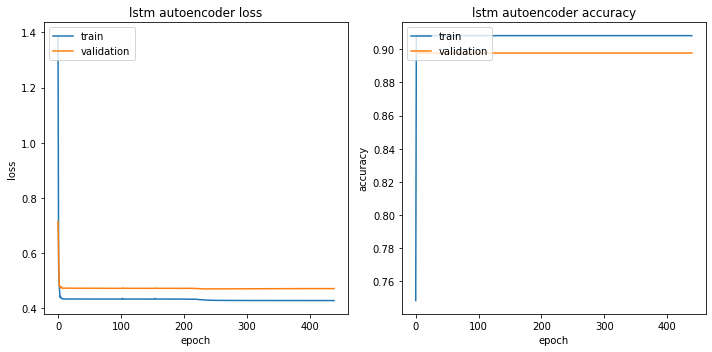

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(ae_hist.history['loss'], label='training')
  ax1.plot(ae_hist.history['val_loss'], label='validation')
  ax1.set_title('lstm autoencoder loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(ae_hist.history['accuracy'], label='training')
  ax2.plot(ae_hist.history['val_accuracy'], label='validation')
  ax2.set_title('lstm autoencoder accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [ ]:
def save_hist():
  filename = data_path + "ae_viridae_reconstruction_history.csv"
  hist_df = pd.DataFrame(ae_hist.history) 
  with open(filename, mode='w') as f:
    hist_df.to_csv(f)
save_hist()

In [ ]:
# # how to reconstruct the sequence
# idx_to_char = {'0':'T', '1':'N', '2':'G', '3':'C', '4':'A'}
# def show_reconstructions(model, x_seq=xtrain_seq, original_data=xtrain, samples=10):
#   reconstructions = recurrent_ae.predict(x_seq)
#   print('The shape of reconstructions', reconstructions.shape)
#   recon_softmax = np.argmax(reconstructions, axis=-1)
#   for i in range(samples):
#     seq = ''
#     for idx in recon_softmax[i]:
#       seq += idx_to_char[str(idx)]
#     print()
#     print('The {}-th original sequence vs after reconstruction'.format(i))
#     print(original_data['seq'].iloc[i])
#     print(seq)

# show_reconstructions(recurrent_ae, xval_seq, xval)

In [ ]:
# # save model, there seems to be more room for the lstm ae to improve
model_path = '/content/gdrive/My Drive/Colab Notebooks/models/'
recurrent_ae.save(model_path + 'ae(1)_viridae_reconstruct.h5')

In [ ]:
xtrain_vec = encoder.predict(xtrain_seq)
xval_vec = encoder.predict(xval_seq)
xtest_vec = encoder.predict(xtest_seq)
print('The shape of xtrain/xval/xtest_seq is', xtrain_vec.shape, xval_vec.shape, xtest_vec.shape)
filename = 'ae_viridae_raw_'
np.savetxt(data_path + filename + "train.csv", xtrain_vec, delimiter=",")
np.savetxt(data_path + filename + "val.csv", xval_vec, delimiter=",")
np.savetxt(data_path + filename + "test.csv", xtest_vec, delimiter=",")

The shape of xtrain/xval/xtest_seq is (179, 100) (45, 100) (57, 100)


In [ ]:
def plotVec(ax, x, y, title="title"):
  scatter = ax.scatter(x[:, 0], x[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(["red", "blue"]))
  ax.set_title(title)
  ax.legend(*scatter.legend_elements(), loc=0, title="Classes")

In [ ]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score

In [ ]:
# x_big_train = np.vstack((xtrain_vec, xval_vec))
# y_big_train = pd.concat((ytrain,yval))

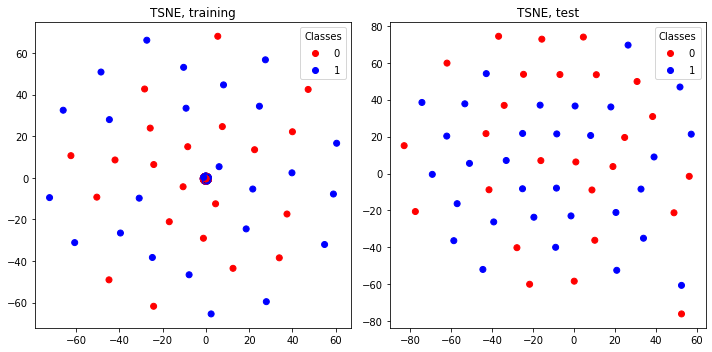

In [ ]:
xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec)
xval_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xval_vec)
xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec)

filename = 'ae_viridae_tsne_'
np.savetxt(data_path + filename + "train.csv", xtrain_tsne, delimiter=",")
np.savetxt(data_path + filename + "val.csv", xval_tsne, delimiter=",")
np.savetxt(data_path + filename + "test.csv", xtest_tsne, delimiter=",")

x_big_train_tsne = np.vstack((xtrain_tsne, xval_tsne))
y_big_train = pd.concat((ytrain,yval))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plotVec(axes[0], x_big_train_tsne, y_big_train, title="TSNE, training")
plotVec(axes[1], xtest_tsne, ytest, title="TSNE, test")
fig.tight_layout()

In [ ]:
# evaluation for whole embedding
x_big_train = np.vstack((xtrain_vec, xval_vec))
train_sil = silhouette_score(x_big_train, y_big_train, metric='cosine')
test_sil = silhouette_score(xtest_vec, ytest, metric='cosine')
print("Whole embedding, silhouette score for training/test embedding is {}/{}".format(train_sil, test_sil))

# evaluation for TSNE embedding
train_sil = silhouette_score(x_big_train_tsne, y_big_train, metric='cosine')
test_sil = silhouette_score(xtest_tsne, ytest, metric='cosine')
print("TSNE embedding, silhouette score for training/test embedding is {}/{}".format(train_sil, test_sil))

Whole embedding, silhouette score for training/test embedding is -0.008928571827709675/0.06857679784297943
TSNE embedding, silhouette score for training/test embedding is -0.002567816060036421/-0.028962504118680954


In [ ]:
model = keras.models.Sequential([
  keras.layers.Dense(128, activation="relu", input_shape=[latent_size]),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(64, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(32, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(16, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(1, activation="sigmoid")                               
])
model.compile(keras.optimizers.SGD(momentum=0.9), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model_hist = model.fit(xtrain_vec, ytrain, validation_data=(xval_vec, yval), epochs=2000, callbacks=[es_cb])

Epoch 1/2000
6/6 [==============================] - 0s 22ms/step - loss: 0.7074 - accuracy: 0.4860 - val_loss: 0.6909 - val_accuracy: 0.5333
Epoch 2/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.6984 - accuracy: 0.5084 - val_loss: 0.6911 - val_accuracy: 0.5333
Epoch 3/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.6999 - accuracy: 0.5028 - val_loss: 0.6909 - val_accuracy: 0.5333
Epoch 4/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.7008 - accuracy: 0.5028 - val_loss: 0.6913 - val_accuracy: 0.5333
Epoch 5/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5363 - val_loss: 0.6926 - val_accuracy: 0.5333
Epoch 6/2000
6/6 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5196 - val_loss: 0.6928 - val_accuracy: 0.5333
Epoch 7/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.7033 - accuracy: 0.5251 - val_loss: 0.6916 - val_accuracy: 0.5333
Epoch 8/2000
6/6 [=

In [ ]:
def eval_model(model, x, true_label, ds_name="Training"):
  loss, acc = model.evaluate(x, true_label, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}%".format(ds_name, np.round(loss, 3), np.round(acc*100, 2)))

In [ ]:
eval_model(model, xtrain_vec, ytrain, "Training")
eval_model(model, xval_vec, yval, "Validation")
eval_model(model, xtest_vec, ytest, "Test")

Training Dataset: loss = 0.69 and acccuracy = 54.19%
Validation Dataset: loss = 0.691 and acccuracy = 53.33%
Test Dataset: loss = 0.69 and acccuracy = 54.39%


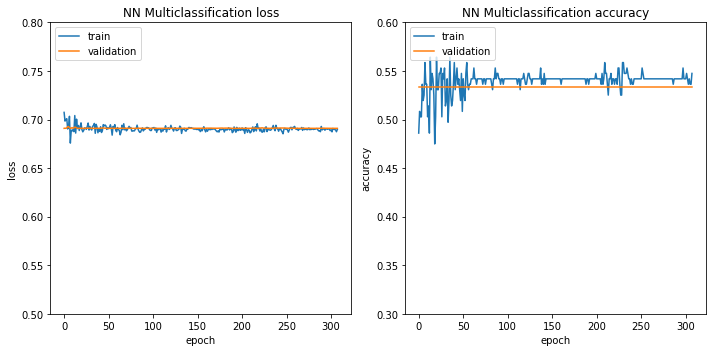

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(model_hist.history['loss'], label='training')
  ax1.plot(model_hist.history['val_loss'], label='validation')
  ax1.set_ylim(0.5, 0.8)
  ax1.set_title('NN Multiclassification loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(model_hist.history['accuracy'], label='training')
  ax2.plot(model_hist.history['val_accuracy'], label='validation')
  ax2.set_ylim(0.3, 0.6)
  ax2.set_title('NN Multiclassification accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [ ]:
def save_hist():
  filename = data_path + "ae_viridae_prediction_history.csv"
  hist_df = pd.DataFrame(model_hist.history) 
  with open(filename, mode='w') as f:
    hist_df.to_csv(f)
save_hist()

In [ ]:
# # save model, there seems to be more room for the lstm ae to improve
model_path = '/content/gdrive/My Drive/Colab Notebooks/models/'
model.save(model_path + 'ae(1)_viridae_prediction.h5')